In [ ]:
# !conda install -y -c conda-forge ffmpeg

In [438]:
import json
from pathlib import Path
import itertools
import os

import dgl
import dgl.function as fn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn.pytorch import GraphConv
from dgl import DGLGraph


In [378]:
results_dir = '/data/results/08162020'
Path(results_dir).mkdir(parents=True, exist_ok=True)

## protein GCN example

In [2]:
driver_genes = pd.read_csv('/data/driver_genes/ucec_drivers.tsv', sep='\t')
drivers = set(driver_genes['gene'])
driver_genes

,gene,Tumor suppressor or oncogene prediction (by 20/20+),Cancer
0,TP53,tsg,UCEC
1,CTNNB1,oncogene,UCEC
2,KRAS,oncogene,UCEC
3,PIK3CA,oncogene,UCEC
4,EP300,tsg,UCEC
5,FBXW7,possible tsg,UCEC
6,PPP2R1A,oncogene,UCEC
7,NFE2L2,oncogene,UCEC
8,NRAS,oncogene,UCEC
9,PTEN,tsg,UCEC


In [91]:
driver_genes = pd.read_csv('/data/driver_genes/expanded_drivers.tsv', sep='\t')
expanded_drivers = set(driver_genes['Gene'])
expanded_drivers

{'ABL1',
 'AJUBA',
 'AKT1',
 'ALB',
 'ALK',
 'AMER1',
 'APC',
 'AR',
 'ARAF',
 'ARHGAP35',
 'ARID1A',
 'ARID2',
 'ASXL1',
 'ASXL2',
 'ATM',
 'ATRX',
 'AXIN1',
 'AXIN2',
 'B2M',
 'BAP1',
 'BCL2',
 'BCOR',
 'BRAF',
 'BRCA1',
 'BRD7',
 'CASP8',
 'CCND1',
 'CD79B',
 'CDH1',
 'CDK12',
 'CDK4',
 'CDKN1A',
 'CDKN1B',
 'CDKN2A',
 'CDKN2C',
 'CEBPA',
 'CHD4',
 'CIC',
 'CNBD1',
 'CREBBP',
 'CSDE1',
 'CTCF',
 'CTNNB1',
 'CTNND1',
 'CUL1',
 'CUL3',
 'CYSLTR2',
 'DNMT3A',
 'EEF1A1',
 'EGFR',
 'EGR3',
 'EIF1AX',
 'EP300',
 'EPAS1',
 'EPHA2',
 'EPHA3',
 'ERBB2',
 'ERCC2',
 'ESR1',
 'EZH2',
 'FAT1',
 'FBXW7',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FOXA1',
 'FOXA2',
 'FUBP1',
 'GATA3',
 'GNA11',
 'GNAQ',
 'GNAS',
 'GPS2',
 'GTF2I',
 'HGF',
 'HIST1H1C',
 'HLA-A',
 'HLA-B',
 'HRAS',
 'HUWE1',
 'IDH1',
 'IDH2',
 'IL7R',
 'IRF6',
 'JAK2',
 'JAK3',
 'KANSL1',
 'KDM5C',
 'KDM6A',
 'KEAP1',
 'KIF1A',
 'KIT',
 'KLF5',
 'KMT2A',
 'KMT2B',
 'KMT2C',
 'KMT2D',
 'KRAS',
 'LATS1',
 'LATS2',
 'MACF1',
 'MAP2K1',
 'MAP2K4',

In [3]:
# ## read in data
# df = pd.read_csv('/data/results/ucec_differentials.tsv', sep='\t', index_col='site_id')
# df['driver'] = [0 if g.split(':')[0] not in drivers else 1 for g in df.index]
# dtype_map = {'acetyl': 0, 'phospho': 1, 'ubiquityl':2}
# df['datatype'] = [dtype_map[d] for d in df['datatype']]
# df['gene'] = [x.split(':')[0] for x in df.index]

# # merge genes for now


# df

In [133]:
metadata = pd.read_csv('/data/results/ucec_metadata.tsv', sep='\t', index_col='Unnamed: 0')
metadata.index.name = 'sample_id'
metadata['sample_type'] = ['normal' if 'normal' in x else 'tumor' for x in metadata['sample_type']]
metadata

,case_id,sample_type,aliquot_ids,tmt_experiment,tmt_channel
sample_id,,,,,
S001,C3L-00006,tumor,CPT0001460012,5,128N
S105,C3L-00006,normal,CPT0001470001,5,128C
S002,C3L-00008,tumor,CPT0001300009,16,130N
S003,C3L-00032,tumor,CPT0001420009,2,131
S005,C3L-00090,tumor,CPT0001140003,12,129C
...,...,...,...,...,...
S140,NX5,normal,CPT0189520002;CPT0189520003;CPT0189520004;CPT0...,15,127C
S141,NX6,normal,CPT0189170002;CPT0189170003;CPT0189180002;CPT0...,15,128N
S142,NX7,normal,CPT0183020002;CPT0183050002;CPT0183050003;CPT0...,15,131


In [15]:
complexes = json.load(open('/data/results/corum_complexes.json'))
cs = set([c for ls in complexes for c in ls])
complexes

[['BCL6', 'HDAC4'],
 ['BCL6', 'HDAC5'],
 ['BCL6', 'HDAC7'],
 ['EP300', 'CREBBP', 'KAT2B', 'NCOA3'],
 ['SMC2', 'NCAPH', 'NCAPD2', 'NCAPG', 'SMC4'],
 ['HPS1', 'HPS4'],
 ['HPS6', 'HPS3', 'HPS5'],
 ['CDS1', 'MUS81'],
 ['HDAC3', 'TBL1X', 'NCOR1', 'GPS2', 'CORO2A', 'TBL1XR1'],
 ['SNAPIN',
  'BLOC1S1',
  'BLOC1S3',
  'BLOC1S2',
  'BLOC1S5',
  'DTNBP1',
  'BLOC1S4',
  'BLOC1S6'],
 ['ARPC1B', 'ARPC2', 'ARPC3', 'ARPC5', 'ARPC4', 'ACTR3', 'ACTR2'],
 ['PSME1', 'PSME2'],
 ['PSMD11',
  'PSMD12',
  'PSMD9',
  'PSMD14',
  'PSMD3',
  'PSMD10',
  'PSMC3',
  'PSMC2',
  'PSMC4',
  'PSMD8',
  'PSMD7',
  'PSMD4',
  'PSMC1',
  'PSMC5',
  'PSMC6',
  'PSMD2',
  'PSMD6',
  'PSMD5',
  'PSMD1',
  'PSMD13'],
 ['PFDN6', 'PFDN1', 'VBP1', 'PFDN5', 'PFDN4', 'PFDN2'],
 ['AP1G1', 'AP1G2', 'AP1S2', 'AP1S1', 'AP1B1', 'AP1S3', 'AP1M1', 'AP1M2'],
 ['MTA2', 'MBD3', 'BCL6', 'HDAC1', 'MTA3'],
 ['PSEN1', 'NCSTN', 'APH1A', 'PSENEN'],
 ['PSEN1', 'NCSTN', 'APH1A', 'PSENEN'],
 ['SMARCA5', 'KIF4A', 'SMC2', 'HDAC1', 'SIN3A', 'SMC4', 

In [92]:
df = pd.read_csv('/data/results/ucec_proteome_inputs.tsv', sep='\t', index_col='Unnamed: 0')
df.index = [x.split('_')[0] for x in df.index]
df.index.name = 'gene'
df['driver'] = [0 if g not in drivers else 1 for g in df.index]
df['expanded_driver'] = [0 if g not in expanded_drivers else 1 for g in df.index]
df['gene'] = df.index
df = df[[True if x in cs else False for x in df.index]]
df

,S001,S002,S003,S005,S006,S007,S008,S009,S010,S011,...,S147,S148,S149,S150,S151,S152,S153,driver,expanded_driver,gene
gene,,,,,,,,,,,,,,,,,,,,,
A2M,-0.863000,-1.0700,-1.320000,-1.1900,-0.0206,-0.7080,-0.70800,0.3700,-1.3100,-0.8850,...,1.730000,2.0000,0.2270,0.52000,1.46000,1.2700,0.9040,0,0,A2M
AATF,0.200000,0.0177,-0.319000,0.3380,1.1800,-0.2120,0.17400,1.4000,-0.0736,-0.1100,...,-0.083500,0.1900,0.1220,0.17100,-0.02810,-0.2800,0.1660,0,0,AATF
ABCB1,-0.484000,-0.6880,-0.007970,-0.3630,-0.4150,2.7900,-1.47000,-1.0100,0.0452,-0.0821,...,0.491000,0.1390,-0.3520,-0.00432,1.03000,0.8610,-0.3450,0,0,ABCB1
ABCF2,0.159000,0.5650,0.002500,0.0126,0.4010,0.4620,0.18000,0.5310,0.2340,0.1310,...,0.000052,0.1850,-0.2110,-0.03220,0.11500,-0.0515,-0.0748,0,0,ABCF2
ABI1,-0.166000,-0.0908,-0.268000,0.4330,0.4410,0.0724,-0.35800,-0.3290,0.2350,-0.2140,...,-0.397000,-0.2220,0.0221,-0.16800,-0.19400,-0.2630,-0.2330,0,0,ABI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZW10,0.022900,0.3630,0.010500,-0.0714,-1.2200,0.3970,0.18000,0.1400,-1.1900,0.1750,...,-0.129000,-0.0267,-0.1510,0.14100,-0.38000,-0.1260,0.0234,0,0,ZW10
ZWILCH,0.109000,1.0700,-0.116000,0.0933,-0.5620,-0.9990,0.51300,1.0700,-1.2700,0.2120,...,0.629000,0.6890,0.0552,0.72600,-0.29700,-0.0662,0.4250,0,0,ZWILCH
ZWINT,-0.000315,0.7370,-0.000315,0.1560,0.9370,-0.7300,0.54900,0.6070,-1.2700,-0.3240,...,0.673000,1.0300,0.1050,0.86800,0.04620,-0.0103,0.6770,0,0,ZWINT


In [ ]:
# df = df.groupby('gene').mean()
# df

In [6]:
u, v = [], []

In [7]:
# # def generate_graph(df, complexes):
# genes = [x.split(':')[0] for x in df.index if x.split(':')[0] in cs]
# # for g1 in enumerate(genes):
# #     for i, g2 in enumerate(genes):
        
# gene_to_idxs = {g1:[i for i, g2 in enumerate(genes) if g2 == g1] for g1 in sorted(set(genes))}
# gene_to_idxs  

# def get_combinations(comp):
#     tups = []
#     for i, g1 in enumerate(comp[:len(comp) - 1]):
#         for j, g2 in enumerate(comp[i + 1:]):
#             tups.append((g1, g2))
#     return tups

# # def pair_up_nodes(n1, n2):
# #     for n1 in 

# # get_combinations([1,2,3,4])

# # for i, gene in enumerate(genes):
# #     for comp in complexes:
# #         if gene in comp:
# #             for g in comp:
# tups = []
# for comp in complexes:
#     tups += get_combinations(comp)
# tups = sorted(set(tups))
# print(len(tups))

# idx_tups = set()
# for g1, g2 in tups:
#     if g1 in gene_to_idxs and g2 in gene_to_idxs:
#         idxs1, idxs2 = gene_to_idxs[g1], gene_to_idxs[g2]
#         idx_tups.update([(i1, i2) for i1 in idxs1 for i2 in idxs2])
# print(len(idx_tups))
        
# ## add self links
# for g in genes:
#     idx_tups.update(get_combinations(gene_to_idxs[g]))

# print(len(idx_tups))

In [18]:
gene_to_idx = {g:i for i, g in enumerate(df.index)}

def get_combinations(comp):
    tups = []
    for i, g1 in enumerate(comp[:len(comp) - 1]):
        for j, g2 in enumerate(comp[i + 1:]):
            tups.append((g1, g2))
    return tups

# def pair_up_nodes(n1, n2):
#     for n1 in 

# get_combinations([1,2,3,4])

# for i, gene in enumerate(genes):
#     for comp in complexes:
#         if gene in comp:
#             for g in comp:
tups = []
for comp in complexes:
    tups += get_combinations(comp)
tups = sorted(set(tups))
print(len(tups))

idx_tups = set()
for g1, g2 in tups:
    if g1 in gene_to_idx and g2 in gene_to_idx:
        idx_tups.add((gene_to_idx[g1], gene_to_idx[g2]))
#         idxs1, idxs2 = gene_to_idxs[g1], gene_to_idxs[g2]
#         idx_tups.update([(i1, i2) for i1 in idxs1 for i2 in idxs2])
# print(len(idx_tups))
        
## add self links
# for g in genes:
#     idx_tups.update(get_combinations(gene_to_idxs[g]))

print(len(idx_tups))

39526
34791


In [19]:
idx_tups = sorted(idx_tups)
idx_tups[:10]

[(0, 77),
 (0, 1285),
 (2, 1893),
 (2, 2019),
 (2, 2389),
 (2, 2532),
 (4, 251),
 (4, 738),
 (4, 739),
 (4, 740)]

In [20]:
def build_graph(idx_tups):
    src, dst = zip(*idx_tups)
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    return dgl.DGLGraph((u, v))

In [21]:
G = build_graph(idx_tups)
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 2867 nodes.
We have 69582 edges.


In [ ]:
# # idxs = np.random.choice(np.arange(len(idx_tups)), size=500, replace=False)
# # n = np.asarray(idx_tups)[idxs]
# # n = [(x, y) for x, y in n]
# n_max = df.shape[0]
# n = [t for i, t in enumerate(idx_tups) if t[0] < n_max and t[1] < n_max]
# # n += [(0, 1), (0, 5)]
# # print(n)
# G_subset = build_graph(n)
# print('We have %d nodes.' % G_subset.number_of_nodes())
# print('We have %d edges.' % G_subset.number_of_edges())

In [253]:
# driver_idxs = np.random.choice([x for x in np.where(df['driver']==1)[0]], size=20, replace=False)
# nondriver = [i for i in np.random.choice(np.arange(df.shape[0]), size=50, replace=False) if i not in driver_idxs]
# visualization_idxs = list(nondriver)
# visualization_idxs += list(driver_idxs)
# visualization_idxs = sorted(visualization_idxs)
# visualization_idxs

In [254]:
set(df['driver'])

{0, 1}

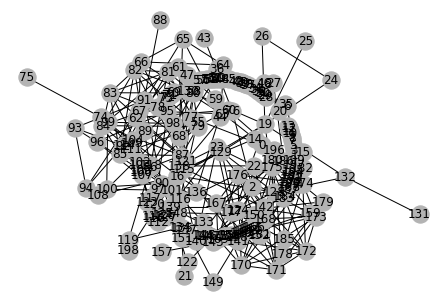

In [255]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.subgraph(list(range(200))).to_networkx().to_undirected()
# nx_G = G.to_networkx().to_undirected()

# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [25]:
X = df.values[:, :-2]
X

array([[-0.863, -1.07, -1.32, ..., 1.46, 1.27, 0.904],
       [0.2, 0.0177, -0.319, ..., -0.0281, -0.28, 0.166],
       [-0.484, -0.688, -0.00797, ..., 1.03, 0.861, -0.345],
       ...,
       [-0.0003150000000000002, 0.737, -0.0003150000000000002, ...,
        0.0462, -0.0103, 0.677],
       [-1.02, -1.13, -0.54, ..., 0.835, 0.416, -0.422],
       [-0.0859, -0.473, -0.419, ..., -0.00809, -0.6579999999999999,
        0.0557]], dtype=object)

In [26]:

G.ndata['feat'] = X.astype(np.float32)


In [27]:
# nn.Embedding(n_max - 1, 3).weight

In [28]:
# embed = nn.Embedding(n_max - 1, 3)  # 34 nodes with embedding dim equal to 3 <fold, pval, type>
# embed.weight = df.iloc[:n_max, :3].values
# G_subset.ndata['feat'] = embed.weight


In [29]:
G.ndata['feat']

tensor([[-8.6300e-01, -1.0700e+00, -1.3200e+00,  ...,  1.4600e+00,
          1.2700e+00,  9.0400e-01],
        [ 2.0000e-01,  1.7700e-02, -3.1900e-01,  ..., -2.8100e-02,
         -2.8000e-01,  1.6600e-01],
        [-4.8400e-01, -6.8800e-01, -7.9700e-03,  ...,  1.0300e+00,
          8.6100e-01, -3.4500e-01],
        ...,
        [-3.1500e-04,  7.3700e-01, -3.1500e-04,  ...,  4.6200e-02,
         -1.0300e-02,  6.7700e-01],
        [-1.0200e+00, -1.1300e+00, -5.4000e-01,  ...,  8.3500e-01,
          4.1600e-01, -4.2200e-01],
        [-8.5900e-02, -4.7300e-01, -4.1900e-01,  ..., -8.0900e-03,
         -6.5800e-01,  5.5700e-02]])

In [283]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [284]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(G.ndata['feat'].shape[1], 16)
        self.layer2 = GCNLayer(16, 16)
        self.layer3 = GCNLayer(16, len(set(df['driver'])))

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        x = self.layer3(g, x)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=144, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (layer3): GCNLayer(
    (linear): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [285]:
# from dgl.data import citation_graph as citegrh
# import networkx as nx
# def load_cora_data():
#     data = citegrh.load_cora()
#     features = torch.FloatTensor(data.features)
#     labels = torch.LongTensor(data.labels)
#     train_mask = torch.BoolTensor(data.train_mask)
#     test_mask = torch.BoolTensor(data.test_mask)
#     g = DGLGraph(data.graph)
#     return g, features, labels, train_mask, test_mask, data

In [286]:
# g, features, labels, train_mask, test_mask, data = load_cora_data()


In [287]:
driver_idxs = [x for x in np.where(df['driver']==1)[0]]
len(driver_idxs)

27

In [288]:
# inputs = embed.weight
features = torch.FloatTensor(G.ndata['feat'])
size = 200
nondriver = [i for i in np.random.choice(np.arange(df.shape[0]), size=size, replace=False) if i not in driver_idxs]
idxs = list(nondriver)
# idxs += list(np.random.choice(driver_idxs, size=15, replace=False))
idxs += list(driver_idxs)
idxs = set(idxs)
train_mask = torch.BoolTensor([True if i in idxs else False for i in range(df.shape[0])])
test_mask = torch.BoolTensor([True if not x else False for x in train_mask])
test_driver_mask = torch.BoolTensor([True if g in expanded_drivers else False
                                     for i, g in enumerate(df.index)])
# driver_mask = torch.BoolTensor([True if i in driver_idxs and i not in idxs else False for i in range(df.shape[0])])

labels = torch.LongTensor(df['driver'].to_list())
ones = torch.LongTensor([1] * df.shape[0])
g = G
# labeled_nodes = torch.tensor(ls)  # only the instructor and the president nodes are labeled

# targets = [0] * len(nondriver)
# targets += [1] * size
# labels = torch.tensor(targets)  # their labels are different

In [289]:
np.count_nonzero(test_mask), np.count_nonzero(test_driver_mask)

(2640, 113)

In [290]:
from sklearn.metrics import f1_score

In [291]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        
        lp = F.log_softmax(logits, 1)
        l = F.nll_loss(lp, labels)
        
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        
        f1 = f1_score(labels, indices)
        
        return correct.item() * 1.0 / len(labels), l, f1

In [292]:
F.nll_loss

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [293]:
import time
import numpy as np
# g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = torch.optim.Adam(net.parameters(), lr=.0005)
dur = []
all_logits = []
for epoch in range(100):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    train_acc, train_l, train_f1 = evaluate(net, g, features, labels, train_mask)
    test_acc, test_l, test_f1 = evaluate(net, g, features, labels, test_mask)
    driver_test_acc, driver_test_l, test_f1 = evaluate(net, g, features, ones, test_driver_mask)
    print("Epoch {:05d} | Loss {:.4f}\n | train loss: {:.4f} | train Acc {:.4f} | train F1 {:.4f}\n | Test loss: {:.4f} | Test Acc {:.4f} | Test F1 {:.4f}\n | D Test loss: {:.4f} | D Test Acc {:.4f} |Time(s) {:.4f}".format(
            epoch, loss.item(), train_l.item(), train_acc, train_f1, test_l.item(), test_acc, test_f1,
        driver_test_l.item(), driver_test_acc, np.mean(dur)))
    

/miniconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/miniconda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 8673.2129
 | train loss: 7291.9600 | train Acc 0.2159 | train F1 0.1982
 | Test loss: 6999.4805 | Test Acc 0.1830 | Test F1 0.8812
 | D Test loss: 495.6443 | D Test Acc 0.7876 |Time(s) nan
Epoch 00001 | Loss 7291.9639
 | train loss: 5958.8457 | train Acc 0.2335 | train F1 0.2091
 | Test loss: 5765.6934 | Test Acc 0.2034 | Test F1 0.8756
 | D Test loss: 746.9985 | D Test Acc 0.7788 |Time(s) nan
Epoch 00002 | Loss 5958.8457
 | train loss: 4739.2246 | train Acc 0.2599 | train F1 0.2150
 | Test loss: 4568.3730 | Test Acc 0.2186 | Test F1 0.8700
 | D Test loss: 1003.2863 | D Test Acc 0.7699 |Time(s) nan
Epoch 00003 | Loss 4739.2256
 | train loss: 3634.7605 | train Acc 0.2687 | train F1 0.1863
 | Test loss: 3450.8137 | Test Acc 0.2617 | Test F1 0.8528
 | D Test loss: 1324.6093 | D Test Acc 0.7434 |Time(s) 0.0648
Epoch 00004 | Loss 3634.7605
 | train loss: 2673.4739 | train Acc 0.2952 | train F1 0.2000
 | Test loss: 2410.3726 | Test Acc 0.2981 | Test F1 0.8351
 | D Test los

Epoch 00040 | Loss 376.2270
 | train loss: 341.9886 | train Acc 0.4890 | train F1 0.1212
 | Test loss: 10.7291 | Test Acc 0.5367 | Test F1 0.6220
 | D Test loss: 2076.3423 | D Test Acc 0.4513 |Time(s) 0.0542
Epoch 00041 | Loss 341.9884
 | train loss: 307.9741 | train Acc 0.4802 | train F1 0.1324
 | Test loss: 12.3732 | Test Acc 0.5212 | Test F1 0.6386
 | D Test loss: 1852.9425 | D Test Acc 0.4690 |Time(s) 0.0541
Epoch 00042 | Loss 307.9740
 | train loss: 274.5094 | train Acc 0.4537 | train F1 0.1389
 | Test loss: 14.2554 | Test Acc 0.4913 | Test F1 0.6706
 | D Test loss: 1630.7032 | D Test Acc 0.5044 |Time(s) 0.0539
Epoch 00043 | Loss 274.5095
 | train loss: 242.9914 | train Acc 0.4405 | train F1 0.1589
 | Test loss: 16.5284 | Test Acc 0.4591 | Test F1 0.7159
 | D Test loss: 1415.2450 | D Test Acc 0.5575 |Time(s) 0.0541
Epoch 00044 | Loss 242.9915
 | train loss: 213.2691 | train Acc 0.4405 | train F1 0.1699
 | Test loss: 19.1368 | Test Acc 0.4311 | Test F1 0.7650
 | D Test loss: 1211.7

Epoch 00080 | Loss 35.6381
 | train loss: 35.2144 | train Acc 0.5154 | train F1 0.1791
 | Test loss: 15.8452 | Test Acc 0.4705 | Test F1 0.6706
 | D Test loss: 132.3215 | D Test Acc 0.5044 |Time(s) 0.0543
Epoch 00081 | Loss 35.2146
 | train loss: 32.0142 | train Acc 0.5110 | train F1 0.1778
 | Test loss: 16.0126 | Test Acc 0.4633 | Test F1 0.6627
 | D Test loss: 112.6815 | D Test Acc 0.4956 |Time(s) 0.0543
Epoch 00082 | Loss 32.0144
 | train loss: 27.7036 | train Acc 0.4934 | train F1 0.1958
 | Test loss: 18.1070 | Test Acc 0.4265 | Test F1 0.6936
 | D Test loss: 76.7488 | D Test Acc 0.5310 |Time(s) 0.0544
Epoch 00083 | Loss 27.7037
 | train loss: 40.3091 | train Acc 0.4581 | train F1 0.1961
 | Test loss: 32.2400 | Test Acc 0.3977 | Test F1 0.7159
 | D Test loss: 63.5576 | D Test Acc 0.5575 |Time(s) 0.0543
Epoch 00084 | Loss 40.3087
 | train loss: 33.3466 | train Acc 0.5330 | train F1 0.1846
 | Test loss: 15.0596 | Test Acc 0.4822 | Test F1 0.6548
 | D Test loss: 125.5448 | D Test Acc 

In [47]:
driver_idxs

[55,
 128,
 164,
 219,
 395,
 517,
 523,
 526,
 725,
 743,
 829,
 1173,
 1221,
 1222,
 1232,
 1342,
 1737,
 1804,
 1805,
 1889,
 1990,
 2038,
 2319,
 2368,
 2485,
 2602,
 2674]

In [250]:
# pg = G.subgraph(list(range(200)))
# # pg = G.subgraph(driver_idxs)
# # pg = G
# def draw(i):
#     pos = {}
#     colors = []
#     print(pg.number_of_nodes())
#     for v in range(200):
#         pos[v] = all_logits[i][v].numpy()
# #         cls = pos[v].argmax()
#         cls = df['driver'][v]
#         colors.append(sns.color_palette()[0] if cls else sns.color_palette()[1])
#     ax.cla()
#     ax.axis('off')
#     ax.set_title('Epoch: %d' % i)
#     print(len(pos), len(colors))
#     nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors, font_size=6,
#             with_labels=True, node_size=100, ax=ax)
# #     nx.draw_networkx(nx_G.to_undirected(), pos, font_size=6,
# #             with_labels=True, node_size=100, ax=ax)

# fig = plt.figure(dpi=150)
# fig.clf()
# ax = fig.subplots()
# draw(0)  # draw the prediction of the first epoch
# # plt.close()

In [251]:
# fig = plt.figure(dpi=150)
# fig.clf()
# ax = fig.subplots()
# draw(30)

In [252]:
# anim = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
# HTML(anim.to_html5_video())

In [300]:
def plot_draw(i, hue='driver'):
    p_df = df.copy()
    emb = np.asarray(all_logits[i].tolist())
    p_df = pd.concat((p_df, pd.DataFrame(data=emb, index=p_df.index, columns=['dim1', 'dim2'])), axis=1)
    p_df['predicted'] = np.argmax(emb, axis=1).flatten()
    p_df['driver_index'] = np.log1p(emb[:, 1].flatten() / emb[:, 0].flatten())
    p_df['expanded_driver'] = [1 if g in expanded_drivers else 0 for g in p_df.index]
    # p_df['driver_index'] = torch.softmax(emb)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    sns.scatterplot(x='dim1', y='dim2', data=p_df, hue=hue, ax=ax)
#     ax.set_xlim((-25, 75))
#     ax.set_ylim((-25, 75))
def plot_draw_groundtruth(i):
    plot_draw(i, hue='driver')
def plot_draw_predicted(i):
    plot_draw(i, hue='predicted')
def plot_draw_expanded_driver(i):
    plot_draw(i, hue='expanded_driver')

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


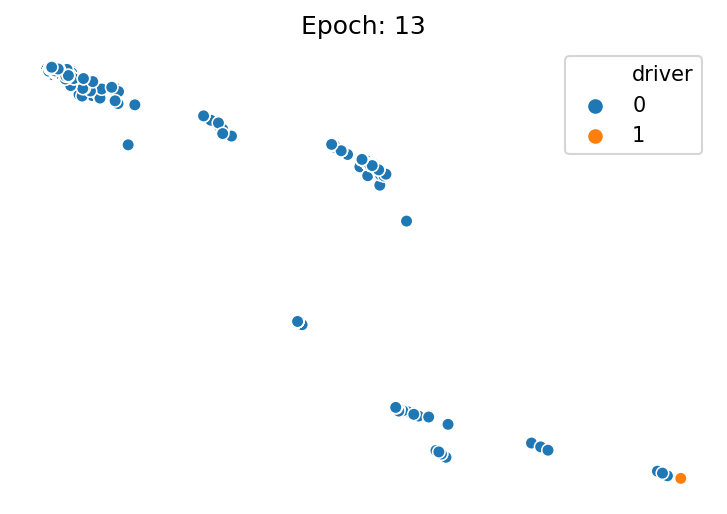

In [297]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
plot_draw(13)

In [381]:
anim = animation.FuncAnimation(fig, plot_draw_predicted, frames=len(all_logits), interval=200)
anim.save(os.path.join(results_dir, 'predicted.mp4'))
HTML(anim.to_html5_video())

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

In [382]:
anim = animation.FuncAnimation(fig, plot_draw_groundtruth, frames=len(all_logits), interval=200)
anim.save(os.path.join(results_dir, 'ucec_drivers.mp4'))
HTML(anim.to_html5_video())

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

In [383]:
anim = animation.FuncAnimation(fig, plot_draw_expanded_driver, frames=len(all_logits), interval=200)
anim.save(os.path.join(results_dir, 'ucec_expanded_drivers.mp4'))
HTML(anim.to_html5_video())

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  
/miniconda/lib/python3.7/site-packages/ipykernel_launche

In [ ]:
all_logits[-1].shape

In [315]:
emb = np.asarray(all_logits[49].tolist())
emb

array([[-0.2145009 ,  0.86635733],
       [-0.22261296, -0.17844974],
       [-1.74743974,  7.48590994],
       ...,
       [-0.86793584, -4.07446146],
       [-0.10811202, -0.13108245],
       [13.11040974, 80.32249451]])

In [316]:
lp = F.log_softmax(torch.tensor(emb), 1)
l = F.nll_loss(lp, labels)
l

tensor(39.3498, dtype=torch.float64)

In [353]:
def score(p3):
    p1 = np.asarray([0, 0])
    p2 = np.asarray([10, 10])
    d = np.linalg.norm(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
    d = np.log10(d)
    if p3[1] < p3[0]: d = d * -1
    return d

In [357]:
p_df['driver_index']

gene
A2M      -0.116746
AATF     -1.505454
ABCB1     0.814844
ABCF2    -2.746513
ABI1      1.238266
            ...   
ZW10      1.231690
ZWILCH   -0.375963
ZWINT    -0.355520
ZYX       1.789346
ZZZ3      1.676932
Name: driver_index, Length: 2867, dtype: float64

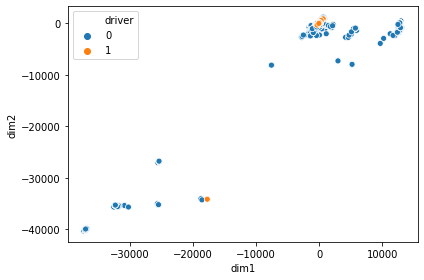

In [401]:
p_df = df.copy()
p_df = pd.concat((p_df, pd.DataFrame(data=emb, index=p_df.index, columns=['dim1', 'dim2'])), axis=1)
p_df['predicted'] = np.argmax(emb, axis=1).flatten()
# p_df['driver_index'] = np.log1p(emb[:, 1].flatten() / (emb[:, 1].flatten() - emb[:, 0].flatten()))
# p_df['driver_index'] = torch.softmax(emb)
p_df['driver_index'] = [score(x) for x in emb]
p_df['expanded_driver_intersect'] = [True if g in expanded_drivers and g not in drivers else False
                                     for g in p_df.index]


hue = 'driver'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_{hue}_hue.pdf'))

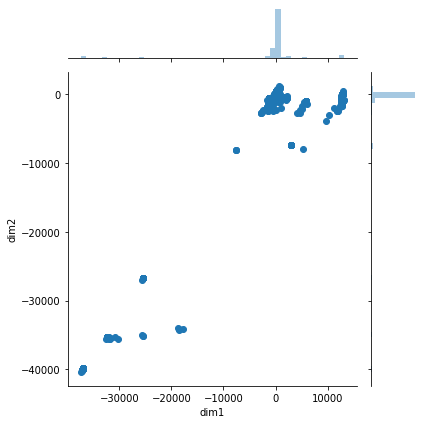

In [406]:
hue = 'driver'
sns.jointplot(x='dim1', y='dim2', data=p_df.sort_values(hue))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_jointplot.pdf'))

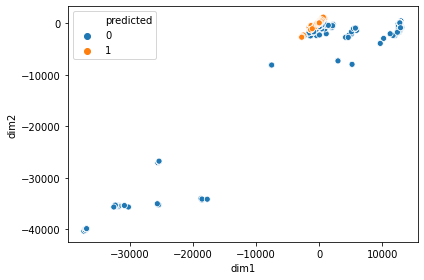

In [400]:
hue = 'predicted'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_{hue}_hue.pdf'))

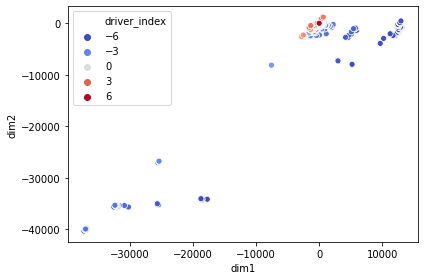

In [399]:
hue = 'driver_index'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue, palette='coolwarm')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_{hue}_hue.pdf'))

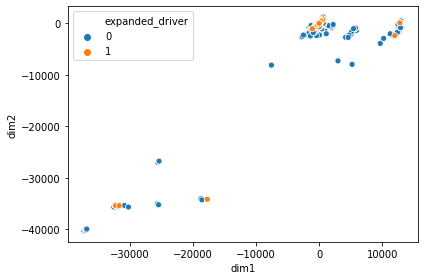

In [398]:
hue = 'expanded_driver'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_{hue}_hue.pdf'))

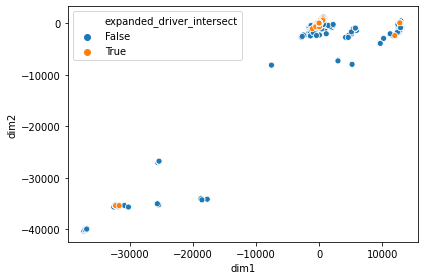

In [397]:
hue = 'expanded_driver_intersect'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'overall_graph_{hue}_hue.pdf'))

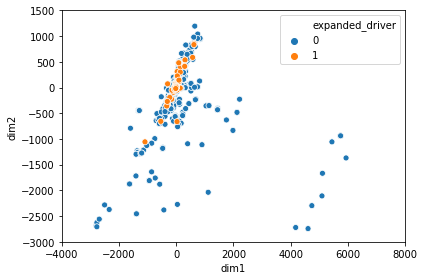

In [409]:
xlim, ylim = (-4000, 8000), (-3000, 1500)

hue = 'expanded_driver'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_graph_{hue}_hue.pdf'))

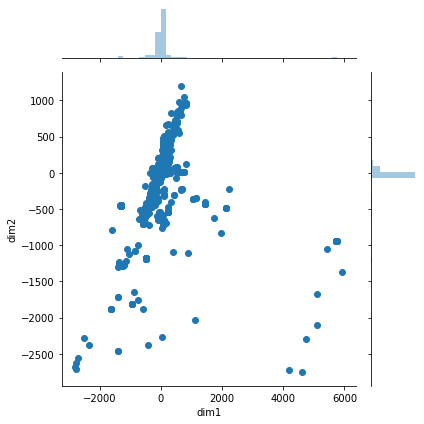

In [412]:
def is_valid_point(x, y, xlim, ylim):
    if x < xlim[1] and x > xlim[0] and y < ylim[1] and y > ylim[0]:
        return True
    return False

filtered = p_df[[is_valid_point(d1, d2, xlim, ylim) for d1, d2 in zip(p_df['dim1'], p_df['dim2'])]]
sns.jointplot(x='dim1', y='dim2', data=filtered)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_graph_jointplot.pdf'))

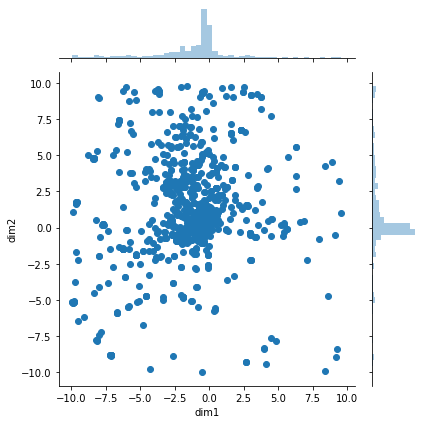

In [416]:

filtered = p_df[[is_valid_point(d1, d2, (-10, 10), (-10, 10)) for d1, d2 in zip(p_df['dim1'], p_df['dim2'])]]
sns.jointplot(x='dim1', y='dim2', data=filtered)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_zoomed_graph_jointplot.pdf'))

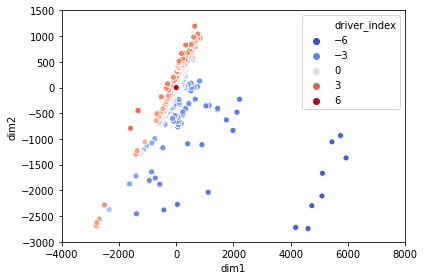

In [417]:
hue = 'driver_index'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue, palette='coolwarm')
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_graph_{hue}_hue.pdf'))

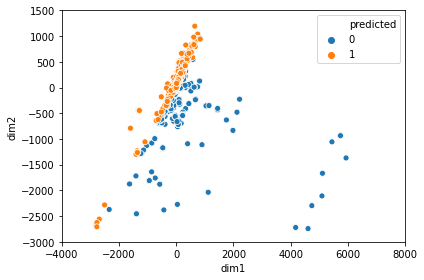

In [419]:
hue = 'predicted'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_graph_{hue}_hue.pdf'))

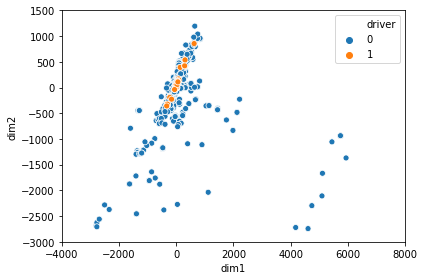

In [420]:
hue = 'driver'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_graph_{hue}_hue.pdf'))

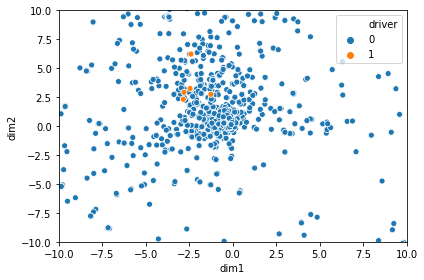

In [421]:
hue = 'driver'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_zoomed_graph_{hue}_hue.pdf'))

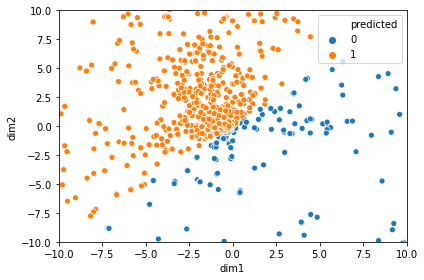

In [422]:
hue = 'predicted'
sns.scatterplot(x='dim1', y='dim2', data=p_df.sort_values(hue), hue=hue)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'zoomed_zoomed_graph_{hue}_hue.pdf'))

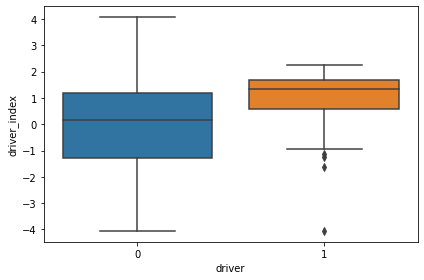

In [424]:
sns.boxplot(x='driver', y='driver_index', data=p_df)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_vs_driver_status.pdf'))

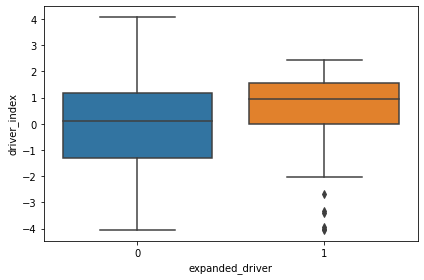

In [426]:
sns.boxplot(x='expanded_driver', y='driver_index', data=p_df)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_vs_expanded_driver_status.pdf'))

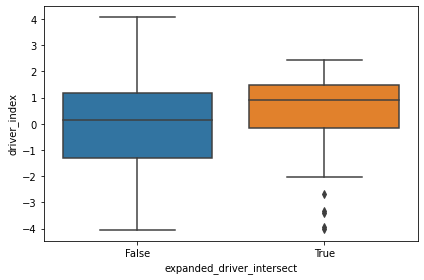

In [427]:
sns.boxplot(x='expanded_driver_intersect', y='driver_index', data=p_df)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_vs_expanded_driver_intersect_status.pdf'))

In [428]:
filtered = p_df[p_df['expanded_driver_intersect']==1].sort_values('driver_index', ascending=False)
filtered

,S001,S002,S003,S005,S006,S007,S008,S009,S010,S011,...,S152,S153,driver,expanded_driver,gene,dim1,dim2,predicted,driver_index,expanded_driver_intersect
gene,,,,,,,,,,,,,,,,,,,,,
MED12,0.09270,0.2950,-0.0742,-0.1670,0.00774,0.2000,0.25600,0.379,0.12900,0.01540,...,-0.1530,0.0243,0,1,MED12,87.172127,480.421753,1,2.444153,True
CUL1,0.00369,-0.2180,0.0489,0.1560,0.26200,0.3240,0.14400,0.211,0.00127,0.00847,...,0.0487,0.0780,0,1,CUL1,-301.794281,71.738892,1,2.421814,True
ESR1,0.76900,-0.3020,-0.1000,0.1290,-2.18000,-0.8920,1.06000,-0.997,-0.72900,0.07940,...,-0.9910,0.8500,0,1,ESR1,30.363426,310.589355,1,2.296993,True
KMT2A,-0.26000,-0.1000,-0.2470,-0.1970,-0.04830,-0.0997,-0.24200,-0.177,-0.20200,-0.07810,...,0.1360,-0.0359,0,1,KMT2A,617.991699,834.793518,1,2.185548,True
TBL1XR1,-0.06330,-0.0393,-0.0688,-0.0507,0.17300,0.0933,0.26800,0.917,0.39500,-0.01280,...,-0.4550,-0.2550,0,1,TBL1XR1,98.517883,298.045898,1,2.149489,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSH2,-0.76700,0.3660,-0.1170,-0.1910,0.21100,0.2290,0.66800,0.679,-0.47100,-0.00513,...,-0.5460,0.2860,0,1,MSH2,28.244452,-662.649109,0,-2.688896,True
NPM1,0.17300,0.3760,0.2730,0.0749,0.17200,-0.4040,-0.16700,0.490,0.14000,0.16300,...,-0.4280,0.3160,0,1,NPM1,-32276.396484,-35390.515625,0,-3.342820,True
EEF1A1,0.14000,0.1370,-0.0413,0.3810,0.53800,0.1650,0.00243,0.372,-0.12700,0.15000,...,-0.2150,-0.3040,0,1,EEF1A1,-31718.167969,-35361.820312,0,-3.411022,True


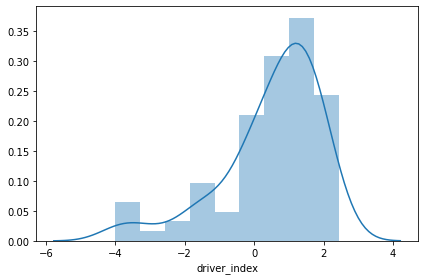

In [433]:
# sns.barplot(x='gene', y='driver_index', data=filtered, color=sns.color_palette()[0])
sns.distplot(filtered['driver_index'])
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_distribution_expanded_drivers.pdf'))

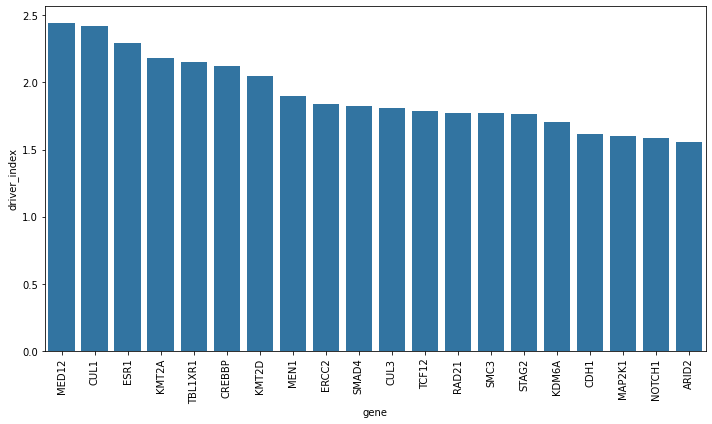

In [440]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x='gene', y='driver_index', data=filtered.iloc[:20, :], color=sns.color_palette()[0], )
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_distribution_top20_expanded_drivers.pdf'))

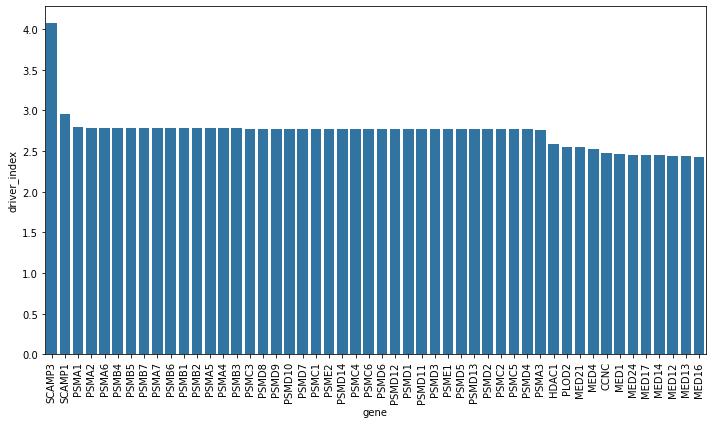

In [444]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x='gene', y='driver_index', data=p_df.sort_values('driver_index', ascending=False).iloc[:50, :],
            color=sns.color_palette()[0], )
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'driver_index_distribution_top50_overall.pdf'))

In [447]:
p_df.sort_values('driver_index', ascending=False)

,S001,S002,S003,S005,S006,S007,S008,S009,S010,S011,...,S152,S153,driver,expanded_driver,gene,dim1,dim2,predicted,driver_index,expanded_driver_intersect
gene,,,,,,,,,,,,,,,,,,,,,
SCAMP3,0.00177,0.2530,0.4190,-0.0462,0.84100,1.46000,0.00317,-0.6760,0.8150,0.2280,...,0.0722,0.3970,0,0,SCAMP3,-0.455495,-0.455613,0,4.075292,False
SCAMP1,0.43900,0.1480,0.5210,0.4940,0.00439,0.25300,0.37800,-0.6680,0.2030,0.1230,...,-0.2500,0.1620,0,0,SCAMP1,-0.472911,-0.474471,0,2.957149,False
PSMA1,0.29100,0.1210,0.1950,0.1380,0.15800,0.32600,0.13600,0.2120,0.5000,0.0691,...,0.1390,0.0105,0,0,PSMA1,-1337.360962,-445.234802,1,2.799911,False
PSMA2,-0.11500,-0.2800,0.1920,-0.4740,-0.17700,-0.12400,0.04470,-0.1750,-0.1780,0.0412,...,0.3390,-0.0879,0,0,PSMA2,-1316.566895,-457.058624,1,2.783735,False
PSMA6,0.23800,-0.0268,0.3410,-0.2920,-0.04890,0.26200,0.15100,-0.1060,0.4220,0.1440,...,-0.0653,-0.2180,0,0,PSMA6,-1316.522949,-457.067139,1,2.783709,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SF3B1,0.31200,0.2400,0.1500,0.0929,0.05870,0.17400,0.42900,0.6570,0.0866,0.0492,...,-0.2520,0.0996,0,1,SF3B1,11987.205078,-2391.408447,0,-4.007202,True
SNU13,0.41000,-0.3410,-0.0230,-0.1540,0.38600,-0.29700,0.16000,-0.0114,-0.2210,-0.0474,...,-0.4720,0.2860,0,0,SNU13,-18750.509766,-34024.199219,0,-4.033429,False
U2AF2,0.24300,-0.0585,-0.1210,0.0410,-0.02000,-0.43600,0.31400,0.3620,-0.1950,0.0729,...,-0.2660,0.1000,0,0,U2AF2,-18578.021484,-34095.519531,0,-4.040307,False


In [445]:
[c for c in complexes if 'SCAMP3' in c]

[['SCAMP3', 'SCAMP1', 'SCAMP2']]

<AxesSubplot:xlabel='driver', ylabel='driver_index'>

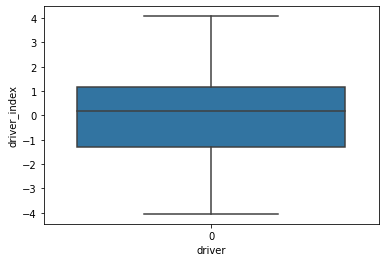

In [360]:
mask = [False if train_mask[i] and d == 1 else True for i, d in enumerate(p_df['driver'])]
sns.boxplot(x='driver', y='driver_index', data=p_df[mask])

In [371]:
expression = pd.merge(df.transpose(), metadata, left_index=True, right_index=True)
expression

,A2M,AATF,ABCB1,ABCF2,ABI1,ABI3,ABL1,ABL2,ABRAXAS1,ABRAXAS2,...,ZW10,ZWILCH,ZWINT,ZYX,ZZZ3,case_id,sample_type,aliquot_ids,tmt_experiment,tmt_channel
S001,-0.863,0.2,-0.484,0.159,-0.166,-0.341,-0.296,-0.18,0.176,0.136,...,0.0229,0.109,-0.000315,-1.02,-0.0859,C3L-00006,tumor,CPT0001460012,5,128N
S002,-1.07,0.0177,-0.688,0.565,-0.0908,-0.943,-0.0897,-0.0563,-0.441,-0.22,...,0.363,1.07,0.737,-1.13,-0.473,C3L-00008,tumor,CPT0001300009,16,130N
S003,-1.32,-0.319,-0.00797,0.0025,-0.268,-0.093,-0.177,0.447,-0.192,-0.0601,...,0.0105,-0.116,-0.000315,-0.54,-0.419,C3L-00032,tumor,CPT0001420009,2,131
S005,-1.19,0.338,-0.363,0.0126,0.433,-0.307,-0.513,-0.124,0.395,0.435,...,-0.0714,0.0933,0.156,-0.797,-0.467,C3L-00090,tumor,CPT0001140003,12,129C
S006,-0.0206,1.18,-0.415,0.401,0.441,0.264,-0.526,0.158,-0.316,-0.231,...,-1.22,-0.562,0.937,-1.85,0.0513,C3L-00098,tumor,CPT0000980012,14,129N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S149,0.227,0.122,-0.352,-0.211,0.0221,-0.907,-0.159,-0.0606,0.0211,-0.0515,...,-0.151,0.0552,0.105,-0.84,0.103,NX14,normal,CPT0230130002;CPT0230130003;CPT0230130004;CPT0...,17,128C
S150,0.52,0.171,-0.00432,-0.0322,-0.168,-0.521,0.13,0.34,-0.00432,-0.202,...,0.141,0.726,0.868,-0.399,-0.0635,NX15,normal,CPT0230190002;CPT0230190003;CPT0230190004,17,131
S151,1.46,-0.0281,1.03,0.115,-0.194,0.822,0.437,0.0124,0.0473,0.0696,...,-0.38,-0.297,0.0462,0.835,-0.00809,NX16,normal,CPT0230250002;CPT0230260002;CPT0230270002;CPT0...,17,129C
S152,1.27,-0.28,0.861,-0.0515,-0.263,0.642,0.231,-0.115,-0.286,0.157,...,-0.126,-0.0662,-0.0103,0.416,-0.658,NX17,normal,CPT0230400002;CPT0230400003;CPT0230400004;CPT0...,17,127C


<AxesSubplot:xlabel='sample_type', ylabel='SCAMP3'>

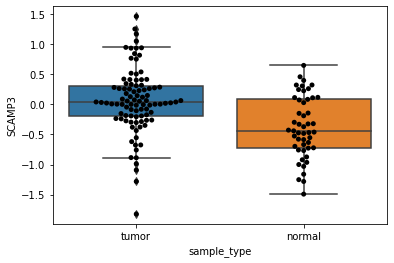

In [446]:
g = 'SCAMP3'
sns.boxplot(x='sample_type', y=g, data=expression)
sns.swarmplot(x='sample_type', y=g, data=expression, color='black')

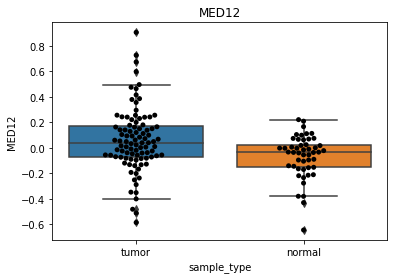

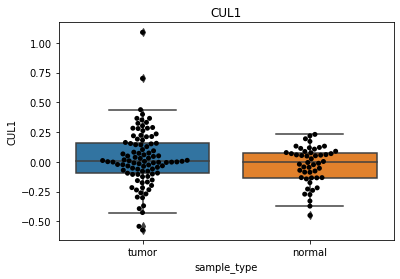

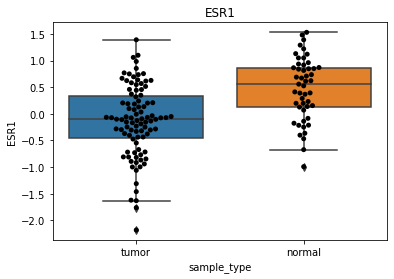

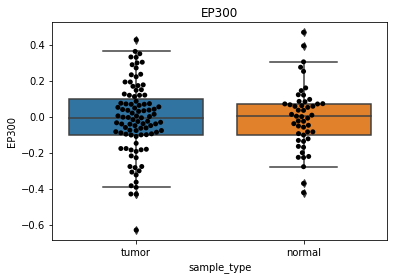

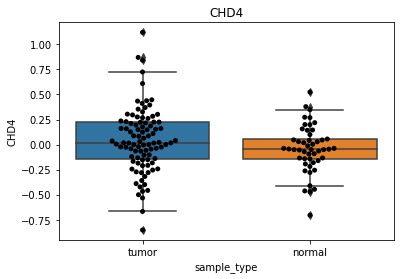

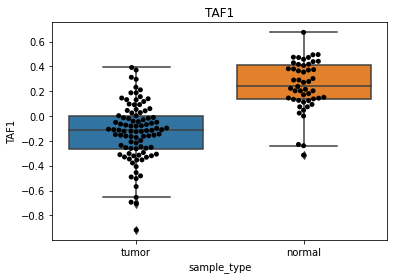

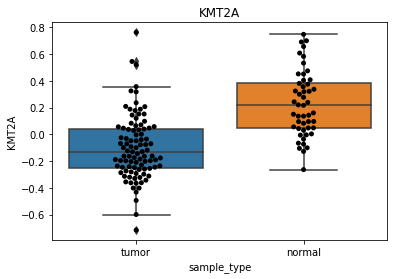

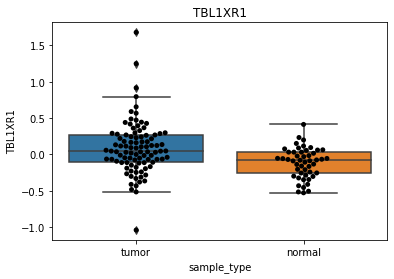

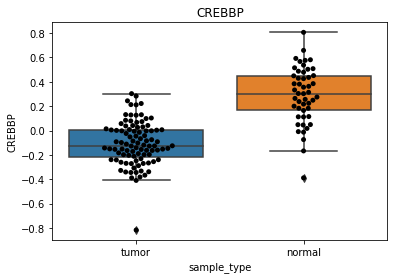

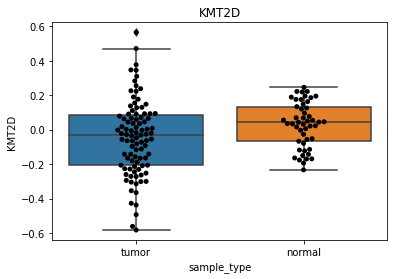

In [374]:
for g in filtered.index[:10]:
    
    sns.boxplot(x='sample_type', y=g, data=expression)
    sns.swarmplot(x='sample_type', y=g, data=expression, color='black')
    plt.title(g)
    plt.show()

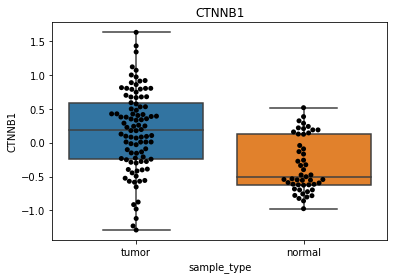

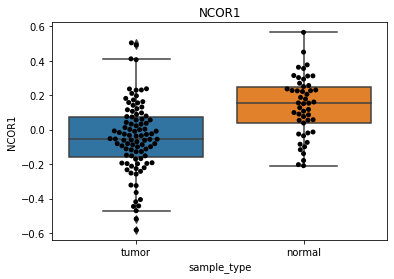

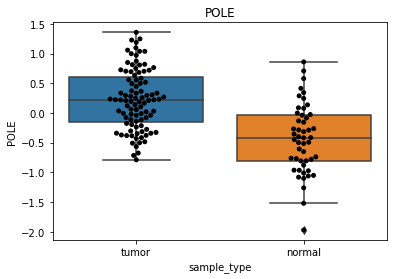

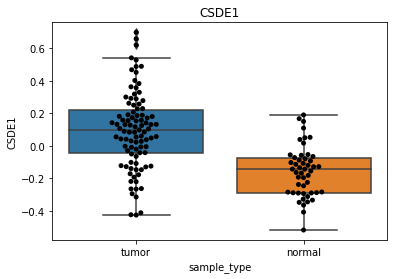

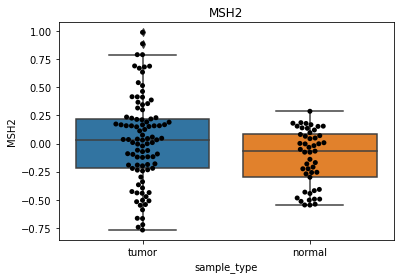

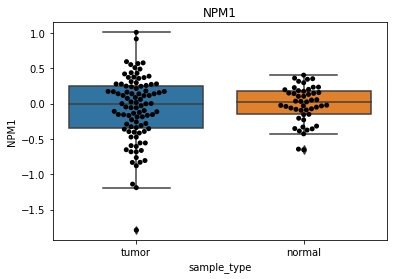

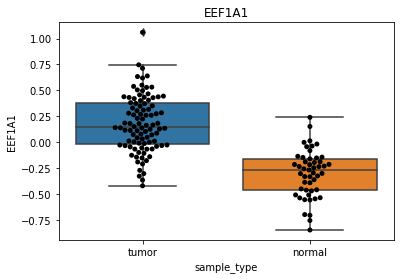

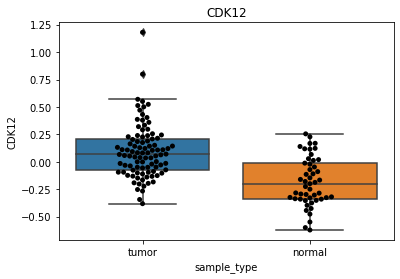

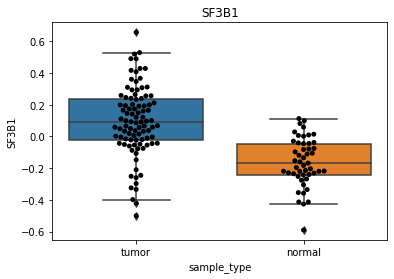

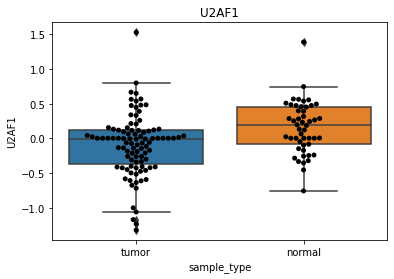

In [375]:
for g in filtered.index[-10:]:
    
    sns.boxplot(x='sample_type', y=g, data=expression)
    sns.swarmplot(x='sample_type', y=g, data=expression, color='black')
    plt.title(g)
    plt.show()

In [ ]:
sns.boxplot(x='sample_type', y='MED12', data=expression)

<AxesSubplot:xlabel='driver', ylabel='tumor/normal_difference'>

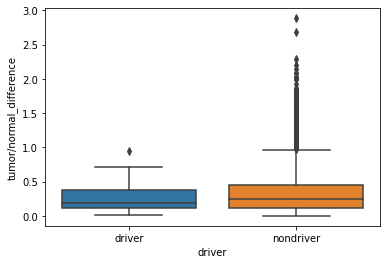

In [169]:
from sklearn.decomposition import PCA
import umap



expression = pd.merge(df.transpose(), metadata, left_index=True, right_index=True).copy()
driver_expression = expression[[d for d in sorted(drivers) if d in expression.columns]].copy()
driver_expression['sample_type'] = expression['sample_type']
driver_expression = driver_expression.fillna(np.inf).groupby('sample_type').mean().replace(np.inf, np.nan)
nondriver_expression = expression[[x for x in df.index if x not in drivers if x in expression.columns]].copy()
nondriver_expression['sample_type'] = expression['sample_type']
nondriver_expression = nondriver_expression.fillna(np.inf).groupby('sample_type').mean().replace(np.inf, np.nan)

driver_foldchange = np.abs(driver_expression.loc['tumor'] - driver_expression.loc['normal'])
nondriver_foldchange = np.abs(nondriver_expression.loc['tumor'] - nondriver_expression.loc['normal'])

fc_df = pd.DataFrame.from_dict({
    'tumor/normal_difference': np.concatenate((driver_foldchange, nondriver_foldchange), axis=0),
    'driver': np.concatenate((['driver']*len(driver_foldchange), ['nondriver']*len(nondriver_foldchange)))
})

sns.boxplot(x='driver', y='tumor/normal_difference', data=fc_df)

In [155]:
driver_expression

,AKT1,ARID1A,ATM,BCOR,CHD4,CTCF,CTNNB1,CTNND1,EP300,ERBB2,...,PIK3CA,PIK3R1,PPP2R1A,PTEN,RB1,SMC1A,SOS1,TAF1,TP53,U2AF1
sample_type,,,,,,,,,,,,,,,,,,,,,
normal,0.094298,0.000967,0.056830,0.043697,-0.042078,0.108642,-0.337094,-0.097061,-0.00364,-0.447227,...,0.296390,0.081027,0.049510,0.481776,-0.445186,0.267485,0.261526,0.244437,-0.114810,0.156231
tumor,-0.098647,-0.156937,-0.117995,0.003238,0.042919,-0.091721,0.172372,0.093539,-0.01480,0.269578,...,-0.146961,-0.112698,-0.033931,-0.465264,0.218564,-0.144591,-0.119069,-0.132296,0.185111,-0.094152


In [128]:
p_df[mask][p_df['driver']==0]['driver_index']

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


gene
A2M       0.589812
AATF           NaN
ABCB1     0.863807
ABCF2     0.518568
ABI1     -0.464598
            ...   
ZW10      0.488987
ZWILCH    0.415108
ZWINT     0.198560
ZYX            NaN
ZZZ3     -0.035827
Name: driver_index, Length: 2840, dtype: float64

In [129]:
import scipy
xs, ys = p_df[mask][p_df['driver']==0]['driver_index'], p_df[mask][p_df['driver']==1]['driver_index']
xs, ys = zip(*[(x, y) for x, y in zip(xs, ys) if not pd.isnull(x) if not pd.isnull(y)])
scipy.stats.ttest_ind(xs, ys)

/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Ttest_indResult(statistic=-2.0153902800155765, pvalue=0.06098138892591313)

In [119]:
p_df.sort_values('driver_index', ascending=False).head(20)

,S001,S002,S003,S005,S006,S007,S008,S009,S010,S011,...,S151,S152,S153,driver,expanded_driver,gene,dim1,dim2,predicted,driver_index
gene,,,,,,,,,,,,,,,,,,,,,
HAUS5,0.2930,0.3320,-0.5300,0.0328,-0.15800,-0.2520,0.1470,-0.0183,-0.1070,0.1950,...,-0.2000,-0.1780,0.10300,0,0,HAUS5,-0.000335,-0.704582,0,7.651915
STAT2,0.2960,-0.2810,-0.1390,-0.7200,0.46300,0.4090,-0.3340,0.5380,0.4050,-0.0909,...,0.3500,0.1630,0.02850,0,0,STAT2,0.000332,0.519600,1,7.355585
PDS5B,-0.1060,-0.5180,-0.0145,-0.6290,-0.47500,-0.3000,0.0393,0.4710,0.1760,-0.0854,...,0.1330,-0.2240,0.34300,0,0,PDS5B,0.002048,1.491004,1,6.591843
CDH2,1.0700,-0.6170,-0.9020,1.2000,-2.19000,1.7800,1.0100,0.4870,-1.7700,1.5800,...,-0.0370,-0.1650,0.19000,0,0,CDH2,-0.002449,-0.626541,0,5.548326
BCL9,0.1300,-0.0338,-0.0329,0.4440,-0.05170,-0.1820,0.1160,0.7250,-0.1270,0.0639,...,-0.2830,-0.4350,0.03270,0,0,BCL9,-0.002449,-0.626541,0,5.548326
AFDN,0.2160,0.3640,0.1930,-0.1530,0.08980,0.3370,0.3570,0.0954,0.3890,0.2560,...,-0.3030,-0.1940,-0.02600,0,0,AFDN,-0.002449,-0.626541,0,5.548326
TSC1,-0.3900,-0.1610,-0.0794,-0.1310,-0.37900,0.1480,-0.1870,-0.4460,0.2970,0.0679,...,0.0391,-0.0814,-0.08630,0,1,TSC1,-0.000521,-0.082310,0,5.067854
FAM126A,-0.6680,-0.5170,-0.5420,-0.8900,-0.93900,-0.8450,-0.3880,-0.4160,-0.1470,-0.1110,...,0.2990,-0.0752,0.12000,0,0,FAM126A,0.001711,0.157283,1,4.531730
PDS5A,0.2750,0.3230,-0.0662,0.0319,0.51400,0.1190,0.4800,0.1130,0.1160,-0.0590,...,-0.1850,-0.2530,0.03760,0,0,PDS5A,0.016793,1.511556,1,4.510994


In [95]:
# p_df = df.copy()
# p_df = pd.concat((p_df, pd.DataFrame(data=emb, index=p_df.index, columns=['dim1', 'dim2'])), axis=1)
# p_df['tumor_normal_median_log2fc'] = p_df['tumor_normal_median_log2fc'].astype(np.float32)
# sns.scatterplot(x='dim1', y='dim2', data=p_df, hue='tumor_normal_median_log2fc', palette='Reds', )
# cbar = plt.colorbar()
# plt.xlim((0, 10))
# plt.ylim((-10, 10))

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

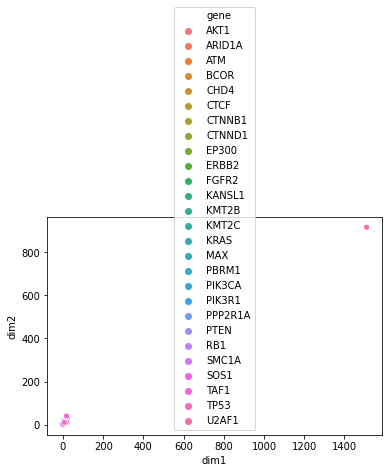

In [80]:
# p_df = df.copy()
# p_df['gene'] = [x.split(':')[0] for x in p_df.index]
driver_df = p_df[p_df['driver']==1]
sns.scatterplot(x='dim1', y='dim2', data=driver_df, hue='gene')

In [83]:
p_df.shape, test_mask.shape

((2867, 148), torch.Size([2867]))

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

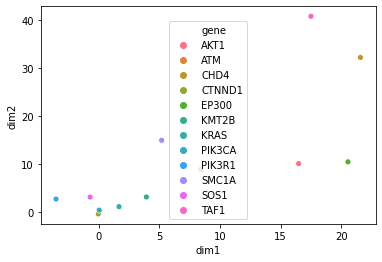

In [84]:
# p_df = df.copy()
# p_df['gene'] = [x.split(':')[0] for x in p_df.index]
driver_df = p_df[np.asarray(test_mask)]
sns.scatterplot(x='dim1', y='dim2', data=driver_df, hue='gene')

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

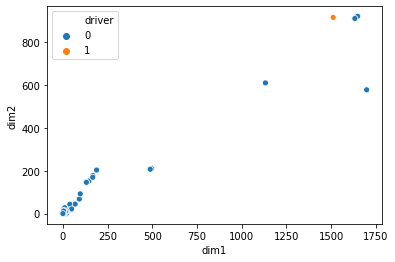

In [86]:
# p_df = df.copy()
# p_df['gene'] = [x.split(':')[0] for x in p_df.index]
driver_df = p_df[np.asarray(train_mask)]
sns.scatterplot(x='dim1', y='dim2', data=driver_df, hue='driver')

(0.0, 100.0)

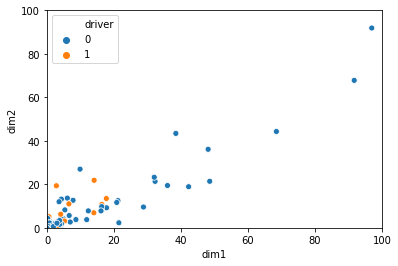

In [89]:
# p_df = df.copy()
# p_df['gene'] = [x.split(':')[0] for x in p_df.index]
driver_df = p_df[np.asarray(train_mask)]
sns.scatterplot(x='dim1', y='dim2', data=driver_df, hue='driver')
plt.xlim(0, 100)
plt.ylim(0, 100)

In [88]:
driver_df[driver_df['driver']==1]

,S001,S002,S003,S005,S006,S007,S008,S009,S010,S011,...,S148,S149,S150,S151,S152,S153,driver,gene,dim1,dim2
gene,,,,,,,,,,,,,,,,,,,,,
ARID1A,-0.8790,-1.4100,-1.04000,0.38500,0.0106,0.20200,0.0622,0.7350,0.51900,-0.086700,...,0.2690,0.2580,0.2630,-0.0109,0.000637,0.2220,1,ARID1A,14.051644,21.857132
BCOR,-0.6300,-0.0775,-0.15600,0.17300,0.4190,0.45700,0.1880,0.0431,-0.48100,-0.157000,...,0.0526,0.1700,0.1600,0.0362,-0.061100,-0.1570,1,BCOR,2.311366,2.223148
CTCF,0.0875,0.2800,-0.56800,0.07230,-0.0150,0.42200,-0.0214,0.0505,0.65700,-0.511000,...,0.4170,0.4830,0.3510,0.0700,-0.306000,0.2550,1,CTCF,13.971827,6.912997
CTNNB1,0.8030,0.4260,0.00891,0.78800,-0.4020,1.43000,0.9710,-0.2520,0.00979,0.591000,...,0.1250,0.3230,0.3850,-0.2580,-0.274000,0.5170,1,CTNNB1,16.355225,10.764686
ERBB2,0.3000,0.4490,0.51600,0.78100,1.6800,0.64400,0.1000,1.2700,0.22900,-0.000666,...,-0.1610,0.3620,-0.0868,-0.5120,-0.479000,-0.1720,1,ERBB2,0.623109,0.333316
FGFR2,1.0300,-0.1640,0.18700,1.60000,1.0800,-1.07000,0.1340,1.9600,0.28400,-0.368000,...,-0.0337,-0.1630,-0.5720,-0.0551,0.425000,-0.5990,1,FGFR2,0.012453,0.938858
KANSL1,-0.2670,0.1110,-0.37100,-0.12400,-0.3560,-0.30300,-0.8050,0.6700,0.16800,-0.145000,...,-0.0676,-0.1190,-0.0429,-0.0463,0.047500,-0.2070,1,KANSL1,2.775544,19.332144
KMT2C,-0.1910,0.7840,0.26200,0.00684,0.2490,-0.29600,0.3600,-0.1120,0.07390,0.050900,...,0.0638,-0.1240,-0.2000,-0.1930,-0.161000,-0.1600,1,KMT2C,5.184513,3.111873
MAX,-0.1110,-0.8850,-0.30200,-0.20200,0.0329,0.11700,0.0744,0.1640,0.36100,-0.214000,...,0.1710,-0.0518,-0.2380,-0.0578,-0.124000,-0.2640,1,MAX,0.553017,5.110577


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

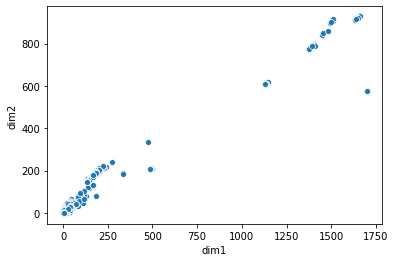

In [85]:
sns.scatterplot(x='dim1', y='dim2', data=p_df)

In [ ]:
driver_df

In [ ]:
driver_df.groupby('gene').mean()

In [ ]:
Counter([x.split(':')[0] for x in df[df['driver']==1].index]).most_common()

In [ ]:
cs = [c for comp in complexes for c in comp]
[(x, y) for x, y in Counter(cs).most_common() if x in drivers]

In [ ]:
from collections import Counter
Counter(p_df['driver']).most_common()

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(3, 3, 2)

In [ ]:
driver_idxs = [x for x in np.where(df['driver']==1)[0] if x < n_max]
driver_idxs

In [ ]:
# inputs = embed.weight
inputs = G_subset.ndata['feat']
size = 100
nondriver = [i for i in np.random.choice(np.arange(n_max), size=size, replace=False) if i not in driver_idxs]
ls = list(nondriver)
ls += list(np.random.choice(driver_idxs, size=size, replace=False))
labeled_nodes = torch.tensor(ls)  # only the instructor and the president nodes are labeled

targets = [0] * len(nondriver)
targets += [1] * size
labels = torch.tensor(targets)  # their labels are different

In [ ]:
labeled_nodes, labels, labeled_nodes.shape, labels.shape

In [ ]:
inputs.shape

In [ ]:
net.parameters()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
# optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G_subset, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

In [ ]:
pg = G_subset.subgraph(visualization_idxs)

def draw(i):
    pos = {}
    colors = []
    for v in range(pg.number_of_nodes()):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(sns.color_palette()[0] if cls else sns.color_palette()[1])
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors, font_size=6,
            with_labels=True, node_size=100, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [ ]:
anim = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(anim.to_html5_video())

In [ ]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [ ]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

In [ ]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [ ]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

In [ ]:
from dgl.nn.pytorch import GraphConv

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [ ]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [ ]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

In [ ]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [ ]:
anim = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)


In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())